In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import numpy as np
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,BaggingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import joblib
import statsmodels.api as sm
from statsmodels.tsa.api import adfuller,seasonal_decompose
import fredapi.fred as fr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,root_mean_squared_error
import mlflow
import mlflow.sklearn

fred = fr.Fred(fred_api_key)




fred = fr.Fred(fred_api_key)

"""The USD/GBP Spot rate"""

usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

data = pd.concat([usdgbp],axis=1).dropna()
data = data.reset_index()
data['Date'] = data['index']
data.drop('index',axis=1,inplace=True)
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head(10)

 


,USDGBP
Date,
1971-01-04,2.3938
1971-01-05,2.3949
1971-01-06,2.3967
1971-01-07,2.3963
1971-01-08,2.3972
1971-01-11,2.3992
1971-01-12,2.4001
1971-01-13,2.4021
1971-01-14,2.4071


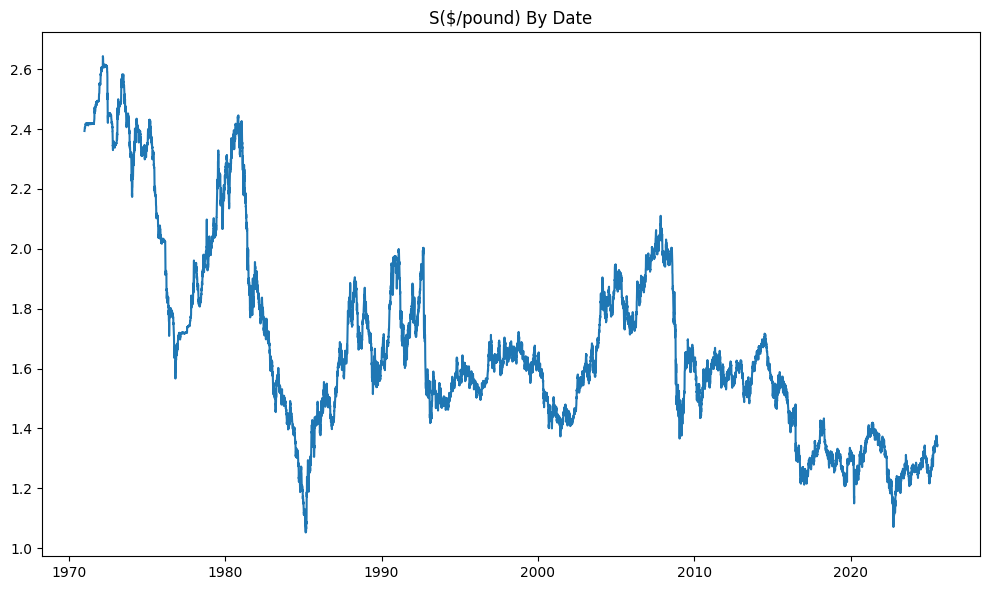

In [2]:
plt.figure(figsize=(10,6))
plt.plot(df['USDGBP'])
plt.title("S($/pound) By Date")
plt.tight_layout()
plt.show()



C:\Users\katsa\AppData\Local\Temp\ipykernel_19300\910597658.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  seasonal_decomp.plot().show()


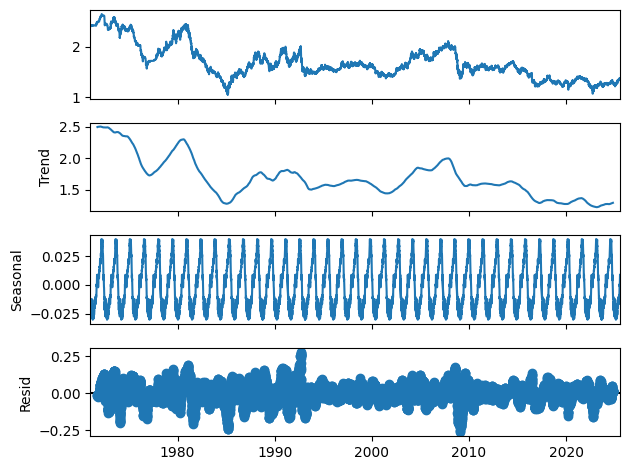

In [3]:
seasonal_decomp = seasonal_decompose(x=df,model="additive",period=365)
seasonal_decomp.plot().show()

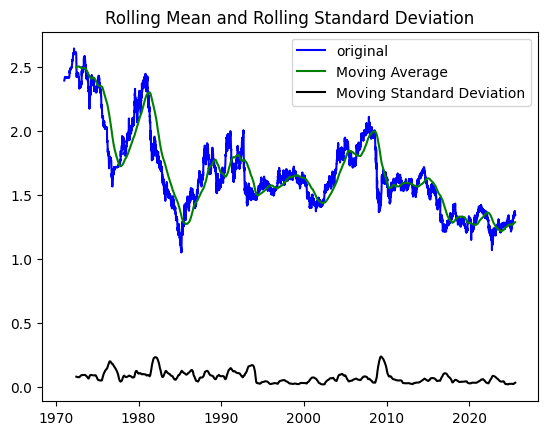

Results from Dickey Fueller

Test Statistic                    -2.517314
p-value                            0.111318
'#Lags Used                       28.000000
Number of Observations Used    13649.000000
Critical Value (1%)               -3.430829
Critical Value (5%)               -2.861752
Critical Value (10%)              -2.566883
dtype: float64


In [4]:
def test_stationary(timeseries):
    
    movingaverage = timeseries.rolling(window=365).mean()
    movingstd = timeseries.rolling(window=365).std()
    plt.plot(timeseries,color="blue",label="original")
    plt.plot(movingaverage,color="green",label="Moving Average")
    plt.plot(movingstd,color="black",label="Moving Standard Deviation")
    plt.title("TimeSeries For S($/gbp)")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Rolling Standard Deviation")
    plt.show(block=False)
    
    print('Results from Dickey Fueller\n')
    df_test = adfuller(timeseries['USDGBP'],autolag="AIC")
    dfoutput = pd.Series(df_test[0:4],index=['Test Statistic','p-value',"'#Lags Used","Number of Observations Used"])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
test_stationary(df)

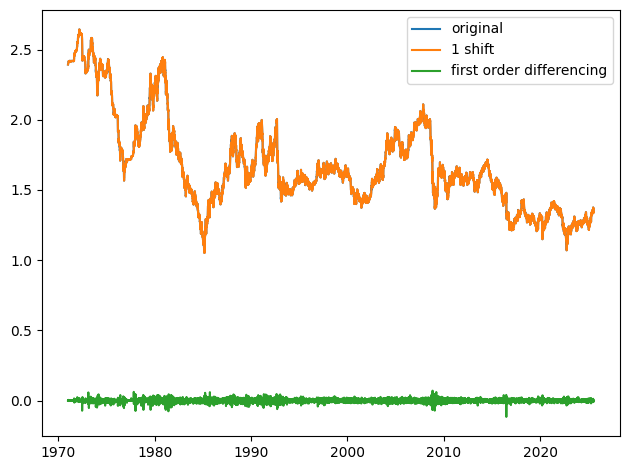

In [5]:
# 1 lag
df_lag1 = df.shift(1)
df_diff1 = df.diff(1)

plt.plot(figsize=(10,6))
plt.plot(df,label="original")
plt.plot(df_lag1,label="1 shift")
plt.plot(df_diff1,label="first order differencing")
plt.legend()
plt.tight_layout()
plt.savefig("images/one shift compared to original")
plt.show()


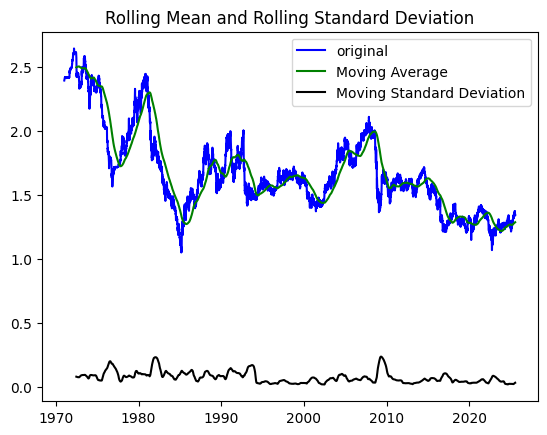

Results from Dickey Fueller

Test Statistic                    -2.514707
p-value                            0.111937
'#Lags Used                       28.000000
Number of Observations Used    13648.000000
Critical Value (1%)               -3.430829
Critical Value (5%)               -2.861752
Critical Value (10%)              -2.566883
dtype: float64


In [6]:
## testing stationary with 1 lag
df_lag1.dropna(inplace=True)
test_stationary(df_lag1)

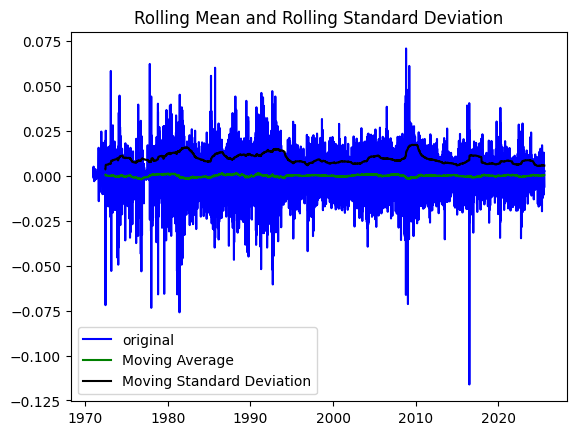

Results from Dickey Fueller

Test Statistic                   -20.261888
p-value                            0.000000
'#Lags Used                       27.000000
Number of Observations Used    13649.000000
Critical Value (1%)               -3.430829
Critical Value (5%)               -2.861752
Critical Value (10%)              -2.566883
dtype: float64


In [7]:
#testing stationary after 1st order differencing
df_diff1.dropna(inplace=True)
test_stationary(df_diff1)

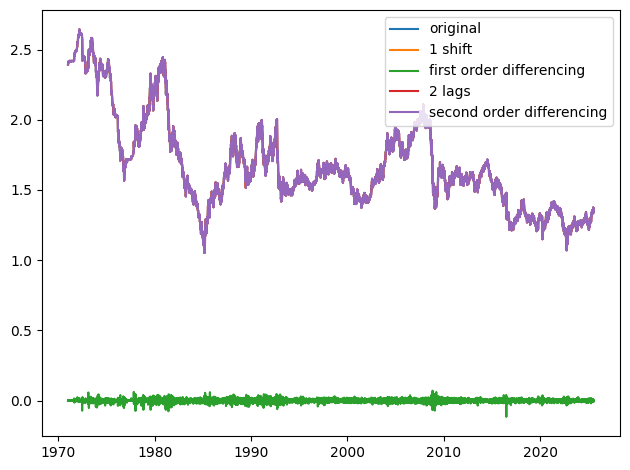

In [8]:
#with two shifts
df_shift2=  df.shift(2)
df_diff2 = df.diff(2)

plt.plot(figsize=(10,6))
plt.plot(df,label="original")
plt.plot(df_lag1,label="1 shift")
plt.plot(df_diff1,label="first order differencing")
plt.plot(df_shift2,label="2 lags")
plt.plot(df_shift2,label="second order differencing")
plt.legend()
plt.tight_layout()
plt.savefig("images/one shift compared to original")
plt.show()

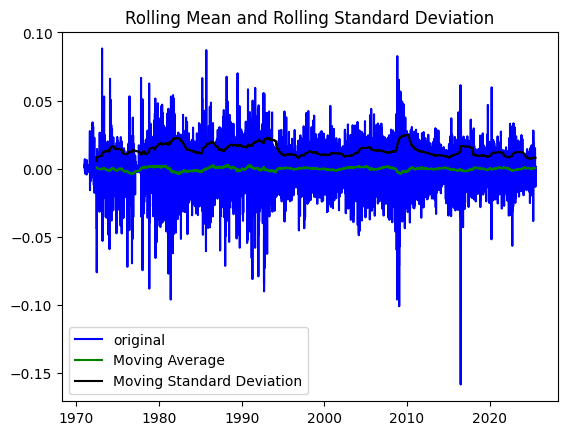

Results from Dickey Fueller

Test Statistic                -1.621504e+01
p-value                        3.950484e-29
'#Lags Used                    4.200000e+01
Number of Observations Used    1.363300e+04
Critical Value (1%)           -3.430830e+00
Critical Value (5%)           -2.861752e+00
Critical Value (10%)          -2.566883e+00
dtype: float64


In [9]:
# testing stationary

df_diff2.dropna(inplace=True)
test_stationary(df_diff2)


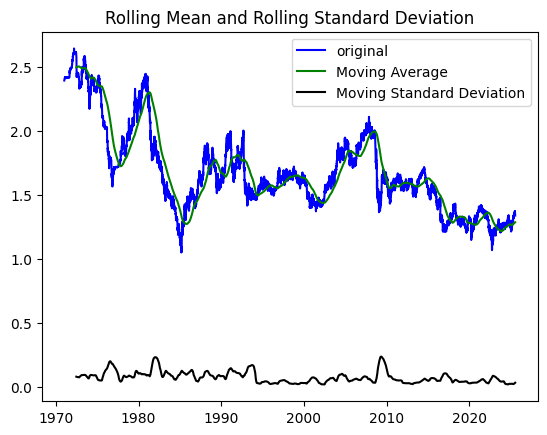

Results from Dickey Fueller

Test Statistic                    -2.513351
p-value                            0.112260
'#Lags Used                       28.000000
Number of Observations Used    13646.000000
Critical Value (1%)               -3.430829
Critical Value (5%)               -2.861752
Critical Value (10%)              -2.566883
dtype: float64


In [10]:
df_shift3 = df.shift(3)
df_shift3.dropna(inplace=True)
test_stationary(df_shift3)

In [11]:

data = data.shift(1)
data.dropna(inplace=True)

In [12]:
X = data.drop('USDGBP',axis=1)
y = data['USDGBP']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.10,random_state=1)


scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


""" A user-Defined function for metrics"""

def evaluate(y_test,pred,model_name,r2,mse,cv_scores):


    result = {
        "Model": model_name,
        "R2": r2,
        "RMSE": mse,
        "Cross-val Scores":cv_scores.mean()
    }

    return result


model_dict = []
models = {
    "LinearRegression":LinearRegression(),
    "lasso":Lasso(),
    "ridge":Ridge(),
    "GradientBoostingRegressor":GradientBoostingRegressor(),
    "BaggingRegressor":BaggingRegressor(),
    "xBGboostRegression":XGBRegressor(),
    "randomforest":RandomForestRegressor(),
}


for model_name,model in models.items():
    model.fit(X_train_scaled,y_train)
    pred = model.predict(X_test_scaled)
    mse = root_mean_squared_error(y_test,pred)
    r2 = r2_score(y_test,pred)
    cv_scores = cross_val_score(model, X_train_scaled,y_train,cv=10,scoring="neg_mean_squared_error")
    model_results = evaluate(y_test, pred, model_name,r2,mse,cv_scores)
    model_dict.append(model_results)



df_results = pd.DataFrame(model_dict)
print(df_results.head(10))





                       Model        R2      RMSE  Cross-val Scores
0           LinearRegression  0.481074  0.250179         -0.056759
1                      lasso -0.005024  0.348166         -0.108239
2                      ridge  0.481022  0.250192         -0.056759
3  GradientBoostingRegressor  0.985723  0.041497         -0.001705
4           BaggingRegressor  0.999331  0.008980         -0.000078
5         xBGboostRegression  0.990270  0.034257         -0.001022
6               randomforest  0.999346  0.008881         -0.000074


In [13]:
mlflow.set_experiment("USDGBP forecast")


linearregression_params = {
'copy_X': [True,False], 
'fit_intercept': [True,False], 
'n_jobs': [1000,5000,10000], 
'positive': [True,False]}



lasso_params = {
    'alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
    }


ridge_params = {
    'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
    }



gradientboosting_params = {
    'n_estimators': [50,100,200],
    'learning_rate': [0.01,0.1,0.2],
    'max_depth': [3,4,5],
    'min_samples_split': [2,5,10]
    }

bagginregression_params = {
    'n_estimators': [50,100,200],
    'max_samples' : [1.0,0.8,0.6],
    'max_features': [1.0,0.8,0.6]
}



xgboost_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}


random_forest_params = {
    'n_estimators': [50,100,200],
    'min_samples_leaf':[1,2,4],
    'max_features': ['sqrt','log2',None],

}



models = {
    "LinearRegression":(LinearRegression(),linearregression_params),
    "lasso":(Lasso(),lasso_params),
    "ridge":(Ridge(),ridge_params),
    "GradientBoostingRegresser":(GradientBoostingRegressor(),gradientboosting_params),
    "baggingREgressor":(BaggingRegressor(),bagginregression_params),
    "xGBRegressor":(XGBRegressor(),xgboost_grid),
    "randomforestregressor":(RandomForestRegressor(),random_forest_params)
    }

best_scores = []

for model_name,(model,params) in models.items():
    grid_search = GridSearchCV(model,params,scoring="neg_root_mean_squared_error",cv=4,n_jobs=-1)
    grid_search.fit(X_train_scaled,y_train)
    print(f'Best Params for {model_name}: {grid_search.best_params_}')
    print(f'Best Score for {model_name}: {grid_search.best_score_}')
    best_scores.append({"Model":model_name,"neg_root_mean_squared_log_error":grid_search.best_score_})
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("best_score", grid_search.best_score_)
        mlflow.sklearn.log_model(grid_search.best_estimator_, model_name)
        best_scores.append({"Model": model_name, "Best Score": grid_search.best_score_})
        mlflow.sklearn.log_model(grid_search.best_estimator_, model_name)
        best_scores.append({"Model": model_name, "Best Score": grid_search.best_score_})



Best Params for LinearRegression: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1000, 'positive': False}
Best Score for LinearRegression: -0.23824030564276938


2025/07/23 22:20:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 22:20:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:20:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 22:20:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:20:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params for lasso: {'alpha': 1e-15}
Best Score for lasso: -0.23824030564276938


2025/07/23 22:21:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:21:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 22:21:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:21:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params for ridge: {'alpha': 1e-15}
Best Score for ridge: -0.23824030564276938


2025/07/23 22:21:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:21:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 22:21:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:22:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params for GradientBoostingRegresser: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best Score for GradientBoostingRegresser: -0.012054379866490213


2025/07/23 22:22:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:22:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 22:22:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:23:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params for baggingREgressor: {'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 200}
Best Score for baggingREgressor: -0.009021439393580757


2025/07/23 22:23:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:23:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 22:23:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:25:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params for xGBRegressor: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
Best Score for xGBRegressor: -0.03204303977978212


2025/07/23 22:25:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:25:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 22:25:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:26:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params for randomforestregressor: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
Best Score for randomforestregressor: -0.00910178777996061


2025/07/23 22:26:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/23 22:26:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 22:27:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [14]:
pred_vs_actual = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': pred
}, index=y_test.index)



pred_vs_actual.sort_index(inplace=True)
print('Predicted Vs Actual Prices\n')
print(pred_vs_actual)

print(pred_vs_actual.head(20))
print(pred_vs_actual.tail(20))

Predicted Vs Actual Prices

       Actual  Predicted
5      2.3972   2.396442
7      2.4001   2.400373
18     2.4161   2.416090
23     2.4184   2.417700
29     2.4158   2.416272
...       ...        ...
13631  1.3318   1.330409
13633  1.3280   1.327187
13639  1.3447   1.337127
13640  1.3426   1.346582
13653  1.3556   1.356288

[1368 rows x 2 columns]
     Actual  Predicted
5    2.3972   2.396442
7    2.4001   2.400373
18   2.4161   2.416090
23   2.4184   2.417700
29   2.4158   2.416272
33   2.4190   2.419155
36   2.4193   2.418638
45   2.4188   2.419153
73   2.4186   2.418337
86   2.4194   2.418550
92   2.4183   2.418055
93   2.4186   2.418322
100  2.4190   2.419278
105  2.4170   2.417168
107  2.4190   2.418244
108  2.4192   2.419034
113  2.4186   2.418892
116  2.4189   2.419194
129  2.4187   2.418231
136  2.4189   2.418629
       Actual  Predicted
13444  1.2766   1.274044
13446  1.2828   1.283190
13456  1.3235   1.318433
13474  1.3351   1.335752
13490  1.3000   1.305736
13498  1.2981 

In [15]:
best_model = RandomForestRegressor(max_features= 'log2',min_samples_leaf= 1,n_estimators=200).fit(X_train_scaled,y_train)
pred = best_model.predict(X_test_scaled)
print(f'Best R2 Score: {r2_score(y_test,pred)}')
print(f'Mean Absolute Squared Error: {root_mean_squared_error(y_test,pred)}')

pred_vs_actual = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': pred
}, index=y_test.index)



pred_vs_actual.sort_index(inplace=True)
print('Predicted Vs Actual Prices using Random Forest\n')
print(pred_vs_actual)

print(pred_vs_actual.head(20))
print(pred_vs_actual.tail(20))

Best R2 Score: 0.9993497636144928
Mean Absolute Squared Error: 0.008855921672115479
Predicted Vs Actual Prices using Random Forest

       Actual  Predicted
5      2.3972   2.396398
7      2.4001   2.400693
18     2.4161   2.416018
23     2.4184   2.417746
29     2.4158   2.415996
...       ...        ...
13631  1.3318   1.330326
13633  1.3280   1.327498
13639  1.3447   1.337477
13640  1.3426   1.345368
13653  1.3556   1.357060

[1368 rows x 2 columns]
     Actual  Predicted
5    2.3972   2.396398
7    2.4001   2.400693
18   2.4161   2.416018
23   2.4184   2.417746
29   2.4158   2.415996
33   2.4190   2.419161
36   2.4193   2.418763
45   2.4188   2.419134
73   2.4186   2.418361
86   2.4194   2.418543
92   2.4183   2.417946
93   2.4186   2.418404
100  2.4190   2.419315
105  2.4170   2.417145
107  2.4190   2.418260
108  2.4192   2.418956
113  2.4186   2.418963
116  2.4189   2.419175
129  2.4187   2.418224
136  2.4189   2.418603
       Actual  Predicted
13444  1.2766   1.274264
13446  1.2